# Kaggle House Prices

## Initialization & utility functions

In [295]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn import model_selection as ms
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor, IsolationForest
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor, RidgeCV, ElasticNetCV
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor

from pandas.api.types import CategoricalDtype

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [296]:
df_train = pd.read_csv('train.csv', index_col=0)
df_test = pd.read_csv('test.csv', index_col=0)
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [297]:
# create ordinal mappings

qualMapping = {'NA':-1, 'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}
expMapping = {'NA':-1, 'No':0, 'Mn':1, 'Av':2, 'Gd':3}
bsmtMapping = {'GLQ':5,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'NA':0}
finishMapping = {'NA':-1, 'Unf':0, 'RFn':1, 'Fin':2}
pvmtMapping = {'N':-1, 'P':0, 'Y':2}

mappings = {}
mappings['ExterQual'] = qualMapping
mappings['ExterCond'] = qualMapping
mappings['BsmtExposure'] = expMapping
mappings['BsmtFinType1'] = bsmtMapping
mappings['BsmtFinType2'] = bsmtMapping
mappings['BsmtQual'] = qualMapping
mappings['BsmtCond'] = qualMapping
mappings['HeatingQC'] = qualMapping
mappings['KitchenQual'] = qualMapping

mappings['FireplaceQu'] = qualMapping
mappings['GarageFinish'] = finishMapping
mappings['GarageQual'] = qualMapping
mappings['GarageCond'] = qualMapping
mappings['PavedDrive'] = pvmtMapping
mappings['PoolQC'] = qualMapping

df_neighborhood = df_train[['Neighborhood', 'SalePrice']].groupby('Neighborhood').mean().sort_values('SalePrice')
df_neighborhood['ID'] = list(range(len(df_neighborhood)))
mappings['Neighborhood'] = df_neighborhood.to_dict()['ID']

In [320]:
oneHotCategoryColumns = set(["MSSubClass", "MSZoning", "Street", "Alley", "LotShape", "LandContour",
                            "LotConfig", "LandSlope", "HouseStyle", "RoofStyle",
                            "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation",
                            "Heating", "CentralAir", "Electrical", "GarageType", "PavedDrive",
                            "SaleType", "SaleCondition", "BldgType", "Fence", "Functional"])

ordinalCategoryColumns = set(["ExterQual", "ExterCond", "BsmtQual",
                            "BsmtCond", "BsmtExposure", "BsmtFinType2", "HeatingQC", "KitchenQual",
                            "FireplaceQu", "GarageFinish", "GarageQual", "GarageCond", "PoolQC",
                            "BsmtFinType1", "Neighborhood"])

numericCategoryColumns = set(["OverallQual", "OverallCond", "GarageCars", "BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath"])

specificOneHotColumns = set(["Utilities", "Condition1", "Condition2", "MiscFeature", "PoolArea", "Neighborhood"])

numericColumns = set(["LotFrontage", "LotArea", "MasVnrArea", "TotalBsmtSF", "LowQualFinSF",
                    "GrLivArea", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces",
                    "GarageYrBlt", "GarageArea", "WoodDeckSF", "OpenPorchSF",
                    "EnclosedPorch", "3SsnPorch", "ScreenPorch", "MiscVal"])

dateTimeColumns = set(["YearBuilt", "YearRemodAdd", 'DateSold'])

from numbers import Number

def preprocessData(df, verbose=False):
    # modify date column
    df.loc[:, 'DateSold'] = df['YrSold'] + df['MoSold'] / 12.0
    
    for col in oneHotCategoryColumns:
        df[col].fillna("NA", inplace=True)
        df = pd.concat([df,pd.get_dummies(df[col], prefix=col, prefix_sep="=")],axis=1)

    for col in ordinalCategoryColumns:
        df[col].fillna("NA", inplace=True)
        catList = list(mappings[col].keys())
        catType = CategoricalDtype(categories=catList, ordered=True)
        df.loc[:, col] = df[col].astype(catType)
        df[col + "Code"] = df[col].cat.codes
    
    for col in numericCategoryColumns:
        df[col].fillna(0.0, inplace=True)
    
    for col in numericColumns:
        # fill na values with interpolate
        df.loc[:, col] = df[col].interpolate(method='akima')
        # normalize
        df.loc[:, col] = (df[col] - df[col].mean()) / df[col].std()
       
    df["MiscFeature"].fillna("None", inplace=True)
    df = pd.concat([df,pd.get_dummies(df["MiscFeature"], prefix="MiscFeature", prefix_sep="=")],axis=1)
    
    df["PoolArea"].fillna(0.0)
    df["HasPool"] = df["PoolArea"] > 0.0   

    # add polynomial columns
    df['OverallQual2'] = df['OverallQual']**2
    df['GrLivArea2'] = df['GrLivArea']**2
    df['ExterQualCode2'] = df['ExterQualCode']**2
    df['NeighborhoodCode2'] = df['NeighborhoodCode'].astype(float)**2
    df['GarageCars2'] = df['GarageCars']**2
    
    df.drop(['BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF'], axis=1, inplace=True)
    
    return df

In [321]:
def dropOutliers(df):
    forest = IsolationForest(max_samples=len(df))
    forest.fit(df_train[list(numericColumns)])

    df['Outliers'] = forest.predict(df[list(numericColumns)])
    df['Outliers'] = df['Outliers'].map({1:False, -1:True})
    df_outliers = df[df['Outliers']]
    df = df.drop(df_outliers.index, axis=0)
    return df

In [332]:
def submit(model, df, features, submissionName):
    y_pred = model.predict(df[features])
    df_submission = pd.DataFrame(index=df.index)
    df_submission['SalePrice'] = y_pred
    df_submission.to_csv('submission.csv', header=True)
    df_submission.head()
    return df_submission
    #!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m str(submissionName)

In [323]:
def testModels(dataframe, features, targetFeature):
    models = [LinearRegression(),
              RidgeCV(alphas=[0.1, 1.0, 10.0]),
              Lasso(alpha=1.0),
              #ElasticNetCV(cv=5),
              #SGDRegressor(max_iter=5, tol=None),
              #GaussianNB(),
              DecisionTreeRegressor(),
              GradientBoostingRegressor(learning_rate=0.1, n_estimators = 100),
              RandomForestRegressor()]

    # preparing X and Y before split
    X_all = dataframe[features]
    Y_all = dataframe[targetFeature]
    X_train, X_valid, Y_train, Y_valid = ms.train_test_split(X_all, Y_all, test_size=0.20)

    modelScores = {}
    for i, mod in enumerate(models):
        # cross validation
        scores = ms.cross_val_score(mod, X_all, Y_all, cv=15)
        print(mod.__class__.__name__.ljust(30), "Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))                                         
        modelScores[mod] = scores.mean()
        
    bestModel = max(modelScores, key=lambda k: modelScores[k])
    bestAccuracy = max(modelScores.values())

    #definitively fit the model on the train data
    bestModel.fit(X_all, Y_all)
    return bestModel, bestAccuracy


## Test Models 1 (3 columns)

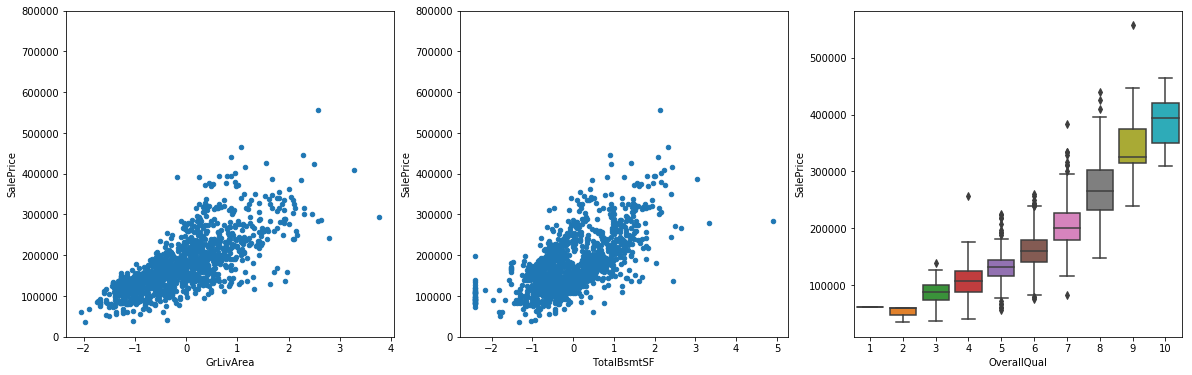

In [324]:
fig, axes = plt.subplots(figsize=(20, 6), nrows=1, ncols=3)
#scatter plot grlivarea/saleprice
data = pd.concat([df_train['SalePrice'], df_train['GrLivArea']], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice', ylim=(0,800000),ax=axes[0])

#scatter plot totalbsmtsf/saleprice
data = pd.concat([df_train['SalePrice'], df_train['TotalBsmtSF']], axis=1)
data.plot.scatter(x='TotalBsmtSF', y='SalePrice', ylim=(0,800000),ax=axes[1]);

#box plot overallqual/saleprice
data = pd.concat([df_train['SalePrice'], df_train['OverallQual']], axis=1)
fig = sb.boxplot(x='OverallQual', y="SalePrice", data=data, ax=axes[2])


In [325]:
df_train = df_train_raw.copy()
df_train = preprocessData(df_train, verbose = False)
df_train = dropOutliers(df_train)
simplestFeatures = ['GrLivArea', 'OverallQual', "TotalBsmtSF"]
className = 'SalePrice'
bestModel, bestAccuracy = testModels(df_train, simplestFeatures, className)

LinearRegression               Accuracy: 0.79 (+/- 0.03)
RidgeCV                        Accuracy: 0.79 (+/- 0.03)
Lasso                          Accuracy: 0.79 (+/- 0.03)
DecisionTreeRegressor          Accuracy: 0.69 (+/- 0.06)
GradientBoostingRegressor      Accuracy: 0.82 (+/- 0.04)
RandomForestRegressor          Accuracy: 0.79 (+/- 0.05)


In [335]:
df_test = df_test_raw.copy()
df_test = preprocessData(df_test, verbose = False)
submit(bestModel, df_test, simplestFeatures, className)
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m "3 features"

Successfully submitted to House Prices: Advanced Regression Techniques


## Test Models 2 (6 columns)

In [51]:
df_train = df_train_raw.copy()
df_train = preprocessData(df_train)

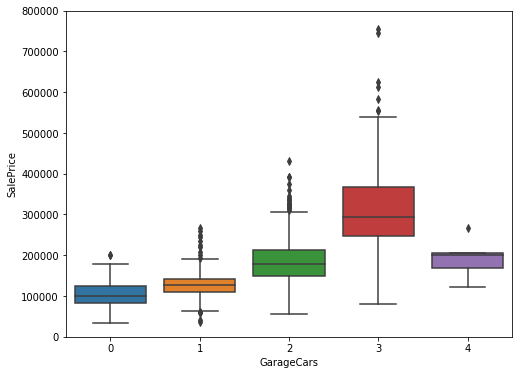

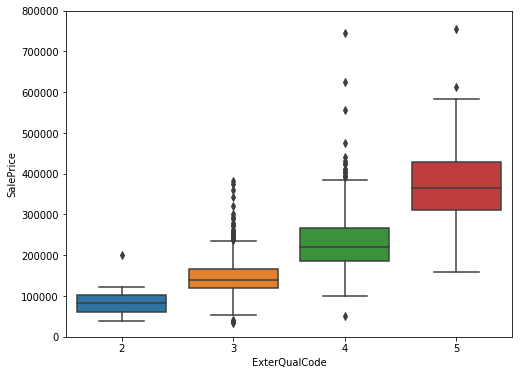

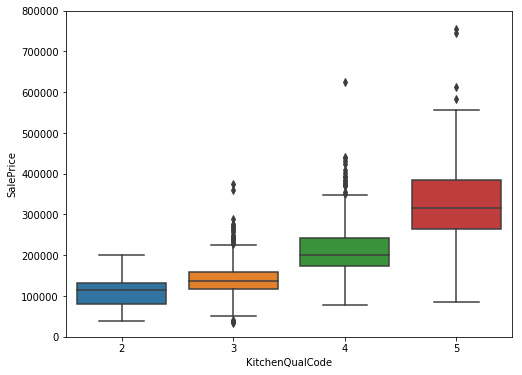

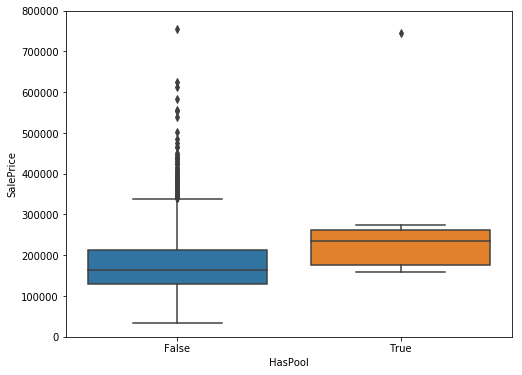

In [53]:
#box plot overallqual/saleprice
for var in ['GarageCars', 'ExterQualCode', 'KitchenQualCode', 'HasPool']:
    data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
    f, ax = plt.subplots(figsize=(8, 6))
    fig = sb.boxplot(x=var, y="SalePrice", data=data)
    fig.axis(ymin=0, ymax=800000);

In [342]:
df_train = df_train_raw.copy()
df_train = preprocessData(df_train, verbose = False)
df_train = dropOutliers(df_train)

simplestFeatures = ['GrLivArea', 'OverallQual2', "TotalBsmtSF", 'GarageCars', 'ExterQualCode', 'KitchenQualCode', 'NeighborhoodCode2']
className = 'SalePrice'
bestModel, bestAccuracy = testModels(df_train, simplestFeatures, className)

LinearRegression               Accuracy: 0.85 (+/- 0.02)
RidgeCV                        Accuracy: 0.85 (+/- 0.02)
Lasso                          Accuracy: 0.85 (+/- 0.02)
DecisionTreeRegressor          Accuracy: 0.76 (+/- 0.05)
GradientBoostingRegressor      Accuracy: 0.87 (+/- 0.03)
RandomForestRegressor          Accuracy: 0.84 (+/- 0.03)


In [343]:
df_test = df_test_raw.copy()
df_test = preprocessData(df_test, verbose = False)
submit(bestModel, df_test, simplestFeatures, className)
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m "7 features with NeigborhoodCode2"

Successfully submitted to House Prices: Advanced Regression Techniques


## Correlation

In [344]:
df_train_raw = pd.read_csv('train.csv', index_col=0)
df_train = df_train_raw.copy()
df_train = preprocessData(df_train)
corr_matrix = df_train.corr().abs()
#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
os = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)).stack().sort_values(ascending=False))
os[:20]

CentralAir=N           CentralAir=Y          1.000
Street=Grvl            Street=Pave           1.000
MSSubClass=90          BldgType=Duplex       1.000
Exterior1st=CBlock     Exterior2nd=CBlock    1.000
ExterQualCode          ExterQualCode2        0.996
PoolArea               HasPool               0.990
OverallQual            OverallQual2          0.988
SaleCondition=Partial  SaleType=New          0.987
YrSold                 DateSold              0.986
MSSubClass=190         BldgType=2fmCon       0.983
Exterior1st=VinylSd    Exterior2nd=VinylSd   0.978
Exterior1st=CemntBd    Exterior2nd=CmentBd   0.974
Exterior1st=MetalSd    Exterior2nd=MetalSd   0.973
NeighborhoodCode       NeighborhoodCode2     0.967
GarageQualCode         GarageCondCode        0.959
PoolQCCode             HasPool               0.954
MiscFeature=None       MiscFeature=Shed      0.951
GarageCars             GarageCars2           0.950
GarageType=NA          GarageCondCode        0.946
                       GarageQu

Index(['SalePrice', 'OverallQual2', 'OverallQual', 'NeighborhoodCode2',
       'GrLivArea', 'NeighborhoodCode', 'ExterQualCode2', 'ExterQualCode',
       'GarageCars2', 'KitchenQualCode', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'BsmtQualCode', 'FullBath',
       'GarageFinishCode', 'TotRmsAbvGrd', 'YearBuilt', 'FireplaceQuCode'],
      dtype='object')


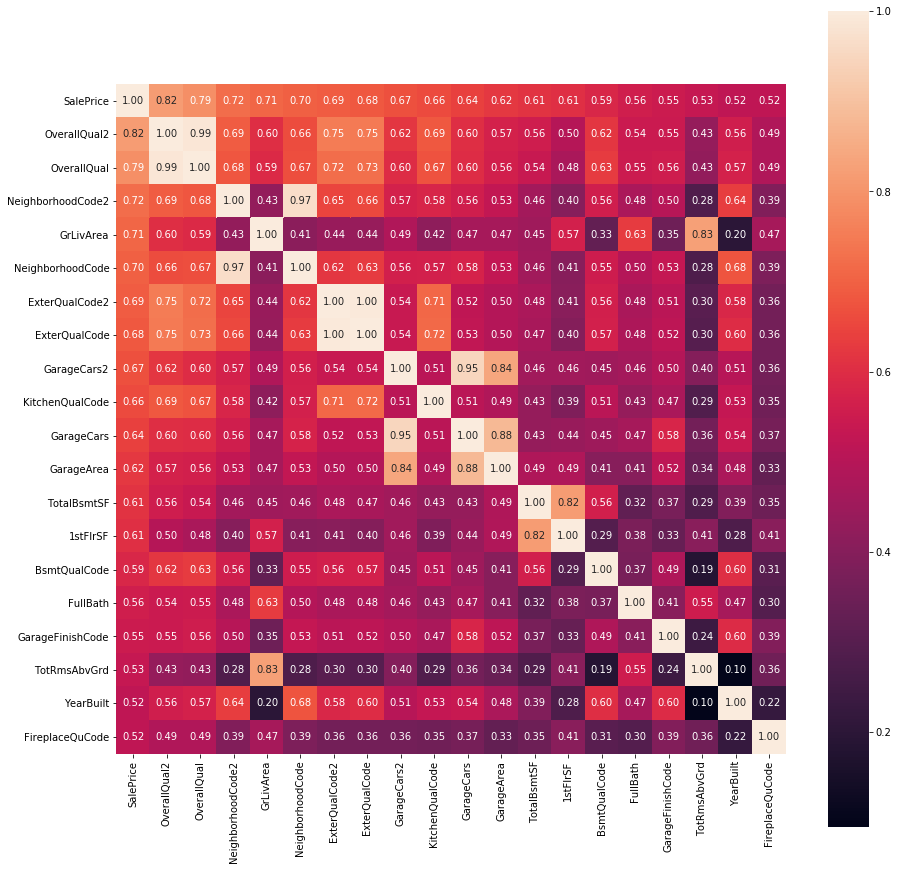

In [345]:
corrmat = df_train.corr()
correlatedColumns = corrmat.nlargest(20, 'SalePrice')['SalePrice'].index
print(correlatedColumns)
corrmat = corrmat.nlargest(20, 'SalePrice')[correlatedColumns]
plt.figure(figsize=(15, 15))
sb.heatmap(corrmat,annot=True,square=True,fmt='.2f',yticklabels=correlatedColumns.values,xticklabels=correlatedColumns.values)
plt.show()

In [346]:
df_train.tail()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,MiscFeature=None,MiscFeature=Othr,MiscFeature=Shed,MiscFeature=TenC,HasPool,OverallQual2,GrLivArea2,ExterQualCode2,NeighborhoodCode2,GarageCars2
Id,,,,,,,,,,,,,,,,,,,,,
1456,60,RL,-0.354,-0.260,Pave,NA,Reg,Lvl,AllPub,Inside,...,1,0,0,0,False,36,0.063,9,196.000,4
1457,20,RL,0.633,0.266,Pave,NA,Reg,Lvl,AllPub,Inside,...,1,0,0,0,False,36,1.126,9,169.000,4
1458,70,RL,-0.182,-0.148,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,0,1,0,False,49,2.462,25,289.000,1
1459,20,RL,-0.096,-0.080,Pave,NA,Reg,Lvl,AllPub,Inside,...,1,0,0,0,False,25,0.693,9,100.000,1
1460,20,RL,0.204,-0.058,Pave,NA,Reg,Lvl,AllPub,Inside,...,1,0,0,0,False,25,0.244,16,16.000,1


In [356]:
correlatedColumnsList = list(correlatedColumns)
correlatedColumnsList.remove('SalePrice')
print(correlatedColumnsList)
bestModel, bestAccuracy = testModels(df_train, correlatedColumnsList, 'SalePrice')

['OverallQual2', 'OverallQual', 'NeighborhoodCode2', 'GrLivArea', 'NeighborhoodCode', 'ExterQualCode2', 'ExterQualCode', 'GarageCars2', 'KitchenQualCode', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'BsmtQualCode', 'FullBath', 'GarageFinishCode', 'TotRmsAbvGrd', 'YearBuilt', 'FireplaceQuCode']
LinearRegression               Accuracy: 0.81 (+/- 0.14)
RidgeCV                        Accuracy: 0.81 (+/- 0.13)


C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to in

Lasso                          Accuracy: 0.81 (+/- 0.14)
DecisionTreeRegressor          Accuracy: 0.71 (+/- 0.18)
GradientBoostingRegressor      Accuracy: 0.88 (+/- 0.05)
RandomForestRegressor          Accuracy: 0.86 (+/- 0.05)


In [349]:
nbFeatures = 20
className = 'SalePrice'

In [363]:
df_train_raw = pd.read_csv('train.csv', index_col=0)
df_train = df_train_raw.copy()
df_train = preprocessData(df_train)

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_train = df_train.select_dtypes(include=numerics)

Y = df_train[className]
X = df_train.drop(className, axis=1)

# Build a forest and compute the feature importances
forest = ExtraTreesRegressor(n_estimators=250, random_state=0)
forest.fit(X, Y)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking ("+str(nbFeatures)+" most important):")

for f in range(nbFeatures):
    print("%d. feature %d (%s) (%f)" %
          (f + 1, indices[f], X.columns[indices[f]], importances[indices[f]]))

Feature ranking (20 most important):
1. feature 34 (OverallQual2) (0.219830)
2. feature 3 (OverallQual) (0.191596)
3. feature 36 (NeighborhoodCode2) (0.103375)
4. feature 37 (GarageCars2) (0.091907)
5. feature 22 (GarageCars) (0.066941)
6. feature 12 (GrLivArea) (0.054621)
7. feature 15 (FullBath) (0.026163)
8. feature 35 (GrLivArea2) (0.025025)
9. feature 9 (1stFlrSF) (0.024146)
10. feature 8 (TotalBsmtSF) (0.020484)
11. feature 10 (2ndFlrSF) (0.016290)
12. feature 20 (Fireplaces) (0.014490)
13. feature 5 (YearBuilt) (0.014003)
14. feature 13 (BsmtFullBath) (0.012610)
15. feature 23 (GarageArea) (0.012151)
16. feature 6 (YearRemodAdd) (0.011510)
17. feature 2 (LotArea) (0.010121)
18. feature 19 (TotRmsAbvGrd) (0.008576)
19. feature 17 (BedroomAbvGr) (0.007432)
20. feature 4 (OverallCond) (0.006574)


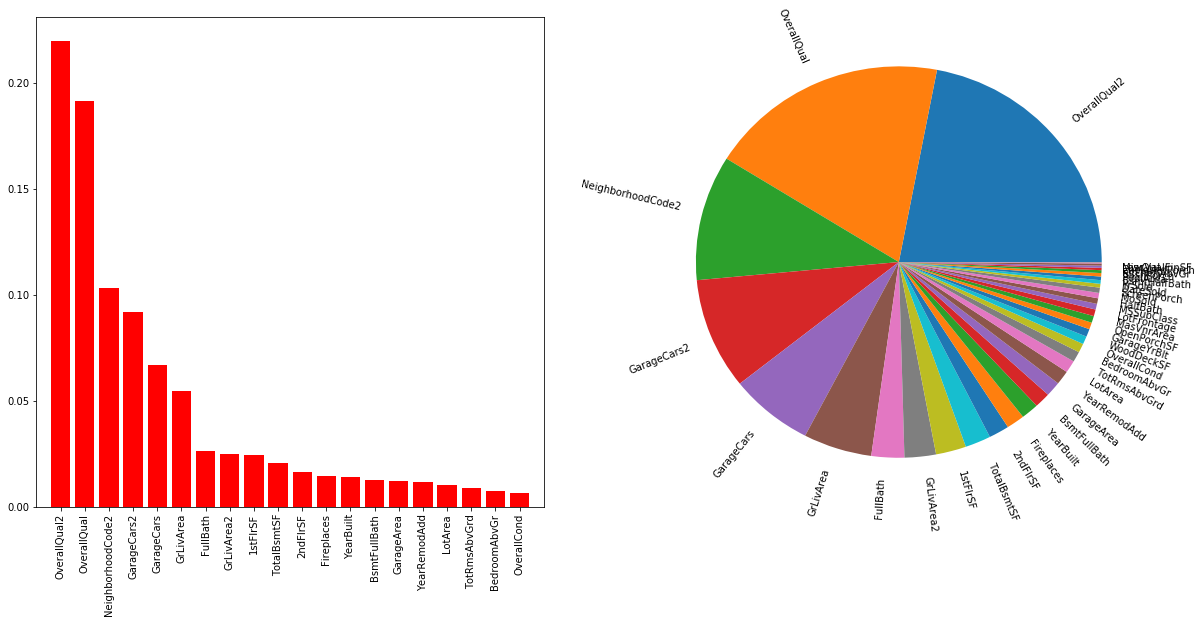

In [364]:
# Plot the feature importances of the forest
plt.figure(figsize=(20, 9))
plt.title("Feature importances")

plt.subplot(1, 2, 1)
plt.bar(range(nbFeatures),importances[indices[:nbFeatures]],color="r",align="center")
plt.xticks(range(nbFeatures), X.columns[indices[:nbFeatures]], rotation=90)
plt.xlim([-1, nbFeatures])

plt.subplot(1, 2, 2)
plt.pie(importances[indices], labels=X.columns[indices], rotatelabels=True)
plt.show()

## Test Model 3 (20 most important features)

In [366]:
featuresNames = ['OverallQual2', 'NeighborhoodCode2', 'GarageCars2', 'GrLivArea', 'FullBath', 'Fireplaces', 'YearBuilt', 'BsmtFullBath', 'YearRemodAdd', 'LotArea', 'TotRmsAbvGrd', 'BedroomAbvGr', 'OverallCond']
print(featuresNames)
bestModel, bestAccuracy = testModels(df_train, featuresNames, 'SalePrice')

['OverallQual2', 'NeighborhoodCode2', 'GarageCars2', 'GrLivArea', 'FullBath', 'Fireplaces', 'YearBuilt', 'BsmtFullBath', 'YearRemodAdd', 'LotArea', 'TotRmsAbvGrd', 'BedroomAbvGr', 'OverallCond']
LinearRegression               Accuracy: 0.82 (+/- 0.09)
RidgeCV                        Accuracy: 0.82 (+/- 0.09)
Lasso                          Accuracy: 0.82 (+/- 0.09)
DecisionTreeRegressor          Accuracy: 0.74 (+/- 0.13)
GradientBoostingRegressor      Accuracy: 0.88 (+/- 0.06)
RandomForestRegressor          Accuracy: 0.85 (+/- 0.06)


In [367]:
print(bestModel)
df_test = df_test_raw.copy()
df_test = cleanData(df_test, verbose = False)
df_test = preprocessData(df_test)
submit(bestModel, df_test, featuresNames, "Best 20")

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)


,SalePrice
Id,
1461,129335.117
1462,151607.447
1463,182206.218
1464,186188.244
1465,180332.827
1466,181630.320
1467,168245.771
1468,179847.314
1469,187067.968


In [368]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m "Most important features"

Successfully submitted to House Prices: Advanced Regression Techniques
